# ECG Signal Classification with Deep Learning: Leveraging Recurrent Neural Network (RNN) for Accurate Arrhythmia Detection

### Connecting with the Google driver

DataSet Used: Sudden Cardiac Death Holter Database

https://drive.google.com/file/d/1OsyI4ytQ6F4kSX6iESjYrgbqUSoJfAC4/view?usp=drive_link

---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


kaggle ECG Dataset: https://www.kaggle.com/datasets/sadmansakib7/ecg-arrhythmia-classification-dataset

### Importing the required dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.utils import to_categorical

### Loading and Analysing the ECG Dataset

Loading ECG Dataset

In [3]:
filepath = '/content/drive/MyDrive/ECG Dataset/Sudden Cardiac Death Holter Database.csv'
data = pd.read_csv(filepath, dtype='object')

Exploratory ECG Dataset Analysis

In [4]:
data.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,30,N,2.0,194.0,0.0032613114624348402,0.15955382698098067,-0.04672563733740808,-0.04672563733740808,-0.12902159927923607,4.0,...,-0.13145054328086112,29.0,17.0,95.0,49.0,-0.13145054328086112,-0.01580885970661799,0.1094934972404279,-0.15362163599272546,-0.20033119945273942
1,30,N,194.0,188.0,-0.05846179128585941,0.06796998862027336,0.2850906173649722,-0.27209265882151684,-0.062109087966537725,25.0,...,-0.04872650965461592,25.0,2.0,76.0,49.0,-0.04872650965461592,0.03465659609149204,0.28226418036949047,-0.013980850329543815,-0.2268711860105882
2,30,N,188.0,194.0,-0.012959400456686896,-0.08974948830990667,0.329466445814664,-0.20465931654079547,-0.01297087132572359,29.0,...,-0.0052562152785730456,29.0,5.0,53.0,19.0,-0.0052562152785730456,0.007638948038945194,0.11619823414356237,0.27155244857577043,-0.11441401044581893
3,30,N,194.0,198.0,-0.03281479971079521,-0.11323553296467287,0.39843719736212396,-0.17819138666939804,-0.06849692070774657,36.0,...,-0.06999231887171818,35.0,26.0,76.0,15.0,-0.06999231887171818,-0.04948891915334409,0.030777281279453263,0.3780753925553463,-0.07438873538915734
4,30,N,198.0,196.0,-0.047353459959422445,0.16483510022363512,0.3646774245194976,-0.2079528206952871,-0.06145691457890758,39.0,...,-0.07200699479729966,35.0,25.0,115.0,55.0,-0.07200699479729966,-0.053250666497615014,0.044583176620691535,0.3132006817928412,-0.15763692536008134


In [5]:
data.shape

(502808, 34)

### Data Preprocessing

Drop rows with missing values

In [6]:
data.dropna(inplace=True)

Extracted features and labels from the dataset

In [8]:
x_data = data.iloc[:, 2:]
y_label = data[['type']]

Handled class imbalance by resampling data

In [9]:
original_class_distribution = data['type'].value_counts()
print("Original class distribution:")
print(original_class_distribution)

Original class distribution:
N       238887
VEB      11266
SVEB      1570
F          210
Q           43
Name: type, dtype: int64


In [10]:
majority_class = original_class_distribution.idxmax()
majority_class_count = original_class_distribution.max()

target_samples = majority_class_count

upsampled_data = pd.DataFrame()

for label in original_class_distribution.index:
    class_data = data[data['type'] == label]

    if label == majority_class:
        upsampled_data = pd.concat([upsampled_data, class_data])
    else:
        upsampled_data = pd.concat([upsampled_data, resample(class_data, replace=True, n_samples=target_samples, random_state=42)])

balanced_class_distribution = upsampled_data['type'].value_counts()
print("\nBalanced class distribution:")
print(balanced_class_distribution)


Balanced class distribution:
N       238887
VEB     238887
SVEB    238887
F       238887
Q       238887
Name: type, dtype: int64


Plot pie charts for the original and balanced class distributions

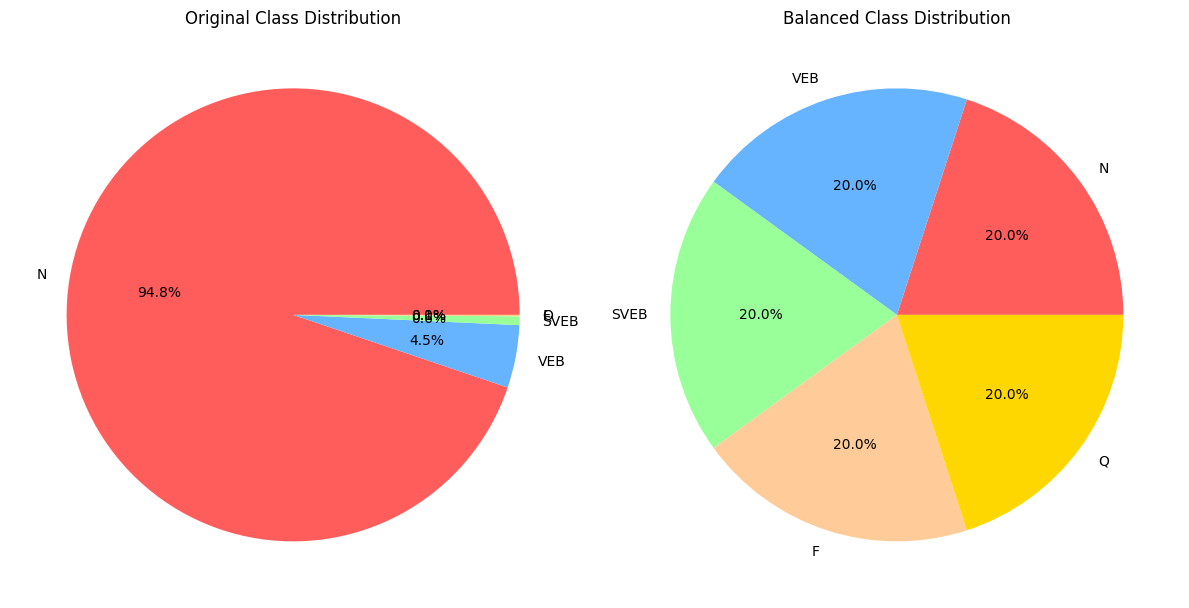

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(original_class_distribution, labels=original_class_distribution.index, autopct='%1.1f%%', colors=['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('Original Class Distribution')

plt.subplot(1, 2, 2)
plt.pie(balanced_class_distribution, labels=balanced_class_distribution.index, autopct='%1.1f%%', colors=['#FF5C5C', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700'])
plt.title('Balanced Class Distribution')

plt.tight_layout()
plt.show()

Handle class imbalance by resampling data

In [12]:
upsampled_data = pd.DataFrame()
target_samples = data['type'].value_counts().max()

for label in data['type'].unique():
    class_data = data[data['type'] == label]
    if len(class_data) < target_samples:
        upsampled_data = pd.concat([upsampled_data, resample(class_data, replace=True, n_samples=target_samples, random_state=42)])
    else:
        upsampled_data = pd.concat([upsampled_data, class_data])

Resampled data

In [13]:
x_data = upsampled_data.iloc[:, 2:]
y_label = upsampled_data['type']

### Label Encoding

Encoded categorical labels

In [16]:
label_encoder = LabelEncoder()
y_label_encoded = label_encoder.fit_transform(y_label)
y_label_one_hot = to_categorical(y_label_encoded)

### Data Splitting

Split the data into training and testing sets

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_label_one_hot, test_size=0.2, random_state=42)

### Scaling the data

Scaled the feature data

In [18]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Reshape for RNN input

In [20]:
x_train_reshaped = x_train_scaled[..., np.newaxis]
x_test_reshaped = x_test_scaled[..., np.newaxis]

print("x_train_reshaped shape:", x_train_reshaped.shape)
print("y_train shape:", y_train.shape)
print("x_test_reshaped shape:", x_test_reshaped.shape)
print("y_test shape:", y_test.shape)

x_train_reshaped shape: (955548, 32, 1)
y_train shape: (955548, 5)
x_test_reshaped shape: (238887, 32, 1)
y_test shape: (238887, 5)


### Model Architecture

Model Definition

In [21]:
model = Sequential([
    SimpleRNN(units=50, activation='tanh', input_shape=(x_train_reshaped.shape[1], 1)),
    Dense(units=len(label_encoder.classes_), activation='softmax')
])

Compile the model


In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Model Training and Evaluation

Evaluate the model on the test set

In [23]:
history = model.fit(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
23889/23889 [==============================] - 205s 9ms/step - loss: 0.1443 - accuracy: 0.9566 - val_loss: 0.0861 - val_accuracy: 0.9773
Epoch 2/10
23889/23889 [==============================] - 200s 8ms/step - loss: 0.0928 - accuracy: 0.9728 - val_loss: 0.0877 - val_accuracy: 0.9725
Epoch 3/10
23889/23889 [==============================] - 198s 8ms/step - loss: 0.0848 - accuracy: 0.9755 - val_loss: 0.0697 - val_accuracy: 0.9791
Epoch 4/10
23889/23889 [==============================] - 199s 8ms/step - loss: 0.0815 - accuracy: 0.9765 - val_loss: 0.0859 - val_accuracy: 0.9741
Epoch 5/10
23889/23889 [==============================] - 209s 9ms/step - loss: 0.0795 - accuracy: 0.9772 - val_loss: 0.0760 - val_accuracy: 0.9773
Epoch 6/10
23889/23889 [==============================] - 204s 9ms/step - loss: 0.0791 - accuracy: 0.9774 - val_loss: 0.0712 - val_accuracy: 0.9810
Epoch 7/10
23889/23889 [==============================] - 206s 9ms/step - loss: 0.0765 - accuracy: 0.9780 - val_

Evaluate the model on the test set

In [24]:
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=0)
print(f'Test set accuracy: {test_accuracy * 100:.2f}%')

Test set accuracy: 98.40%


Making predictions on the test set

In [25]:
y_test_pred_probs = model.predict(x_test_reshaped)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
print(y_test_pred)

7466/7466 [==============================] - 27s 4ms/step
[0 1 0 ... 2 1 2]


Classification Report

In [26]:
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     47767
           1       0.98      0.96      0.97     47578
           2       1.00      1.00      1.00     47855
           3       0.97      0.99      0.98     47750
           4       0.98      0.97      0.98     47937

    accuracy                           0.98    238887
   macro avg       0.98      0.98      0.98    238887
weighted avg       0.98      0.98      0.98    238887



### Final Result Visualization

Plotting the accuracy

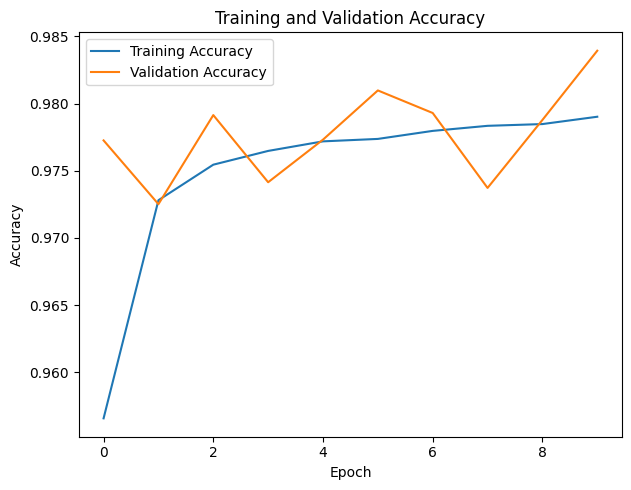

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Plotting the loss

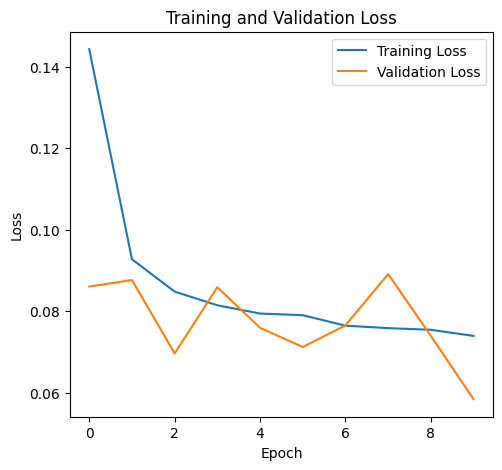

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Plotting the Validation accuracy

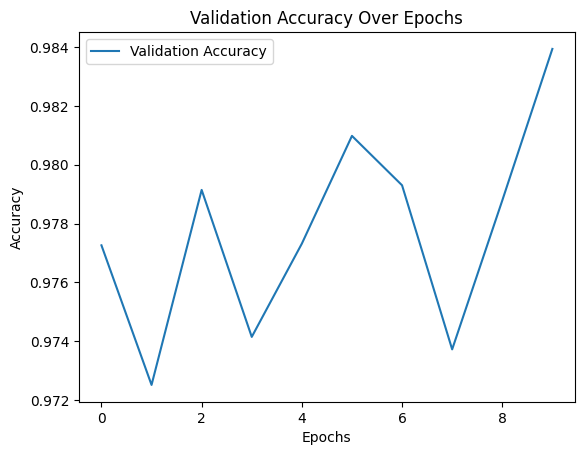

In [29]:
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Plotting the Validation loss

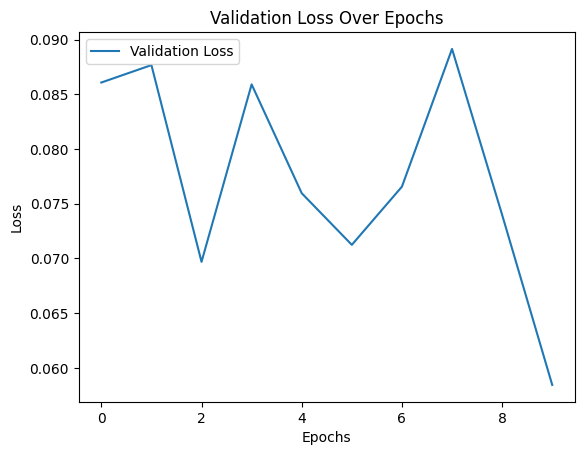

In [30]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model summary

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 2855 (11.15 KB)
Trainable params: 2855 (11.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
